### First, let's import the necessary libraries and configurations.

In [2]:
import numpy as np
import gym
from gym import spaces
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
plt.style.use('dark_background')


In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4887497195606215203
xla_global_id: -1
]


### Now, let's create the same custom `DisasterZone` gym environment as before.

In [4]:
class DisasterZone(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=10, num_obstacles=15, num_survivors=5, num_charging_stations=3, max_battery_life=50):

        super(DisasterZone, self).__init__()

        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_charging_stations = num_charging_stations
        self.max_battery_life = max_battery_life

        # 0: Up, 1: Down, 2: Left, 3: Right
        self.action_space = spaces.Discrete(4)
        # 0: Empty, 1: Obstacle, 2: Survivor, 3: Charging Station
        self.observation_space = spaces.Box(
            low=0, high=3, shape=(grid_size, grid_size), dtype=np.int32)

        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        self.agent_pos = (0, 0)
        self.survivors = {}
        self.battery_life = self.max_battery_life

        # Randomly placing obstacles in the grid
        for _ in range(self.num_obstacles):
            pos = self._random_empty_position()
            self.grid[pos] = 1

        # Randomly placing survivors in the grid
        for i in range(self.num_survivors):
            pos = self._random_empty_position()
            self.grid[pos] = 2
            self.survivors[pos] = i

        # Randomly placing charging stations in the grid
        for _ in range(self.num_charging_stations):
            pos = self._random_empty_position()
            self.grid[pos] = 3

        return self.grid

    def step(self, action):
        new_pos = self.agent_pos
        # Default battery consumption for moving to a new position
        battery_consumption = 1

        if action == 0:  # Up
            new_pos = (max(self.agent_pos[0] - 1, 0), self.agent_pos[1])
        elif action == 1:  # Down
            new_pos = (
                min(self.agent_pos[0] + 1, self.grid_size - 1), self.agent_pos[1])
        elif action == 2:  # Left
            new_pos = (self.agent_pos[0], max(self.agent_pos[1] - 1, 0))
        elif action == 3:  # Right
            new_pos = (self.agent_pos[0], min(
                self.agent_pos[1] + 1, self.grid_size - 1))

        # Check if the new position is the same as the current position
        if new_pos == self.agent_pos:
            return self.grid, -1, False, {}

        # Reward for moving into an empty cell
        reward = -2
        done = False

        if self.grid[new_pos] == 1:
            reward = -3
        elif self.grid[new_pos] == 2:
            euclidean_distance = np.linalg.norm(
                np.array(new_pos) - np.array(self.agent_pos))
            reward = max(10 - int(euclidean_distance), 1)
            self.grid[new_pos] = 0
            del self.survivors[new_pos]
            done = len(self.survivors) == 0
        elif self.grid[new_pos] == 3:
            # Charging the battery instead of consuming it
            battery_consumption = -3

        # Update agent's battery life
        self.battery_life -= battery_consumption

        # Check if the battery life has run out
        if self.battery_life <= 0:
            done = True

        # Calculate reward penalty for low battery life
        reward -= self.max_battery_life - self.battery_life

        # Update agent's position
        self.agent_pos = new_pos

        return self.grid, reward, done, {}

    def render(self, mode='human'):
        grid = self.grid.copy()
        grid[self.agent_pos] = 4

        symbol_mapping = {0: '.', 1: 'X', 2: 'S', 3: 'C', 4: 'A'}
        for row in grid:
            print(' '.join([symbol_mapping[cell] for cell in row]))
            print()

    def close(self):
        pass
    
    def _random_empty_position(self):
        # Finding all the empty positions in the grid where it's not the top-left corner
        empty_positions = np.argwhere((self.grid == 0) & (
            np.arange(self.grid.size).reshape(self.grid.shape) != 0))
        return tuple(empty_positions[np.random.randint(len(empty_positions))])


### Let's define a Q-Learning agent using a Deep Q-Network (DQN) approach for the given `DisasterZone` environment.

In [5]:
class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64):
        self.env = env
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount rate
        self.epsilon = epsilon # exploration rate
        self.epsilon_decay = epsilon_decay # decay rate
        self.epsilon_min = epsilon_min # minimum exploration rate
        self.batch_size = batch_size # batch size

        self.state_size = self.env.observation_space.shape[0] * self.env.observation_space.shape[1]
        self.action_size = self.env.action_space.n

        self.memory = []  # List to store memory transitions

        self.losses = []  # List to store losses per training iteration
        self.exploration_rates = []  # List to store exploration rates per episode

        self.log_dir = "Models/logs/"
        self.tensorboard_callback = TensorBoard(log_dir=self.log_dir)

        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        self.exploration_rates.append(self.epsilon)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch_indices = np.random.choice(len(self.memory), batch_size, replace=False)
        minibatch = [self.memory[i] for i in minibatch_indices]
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_q_values = self.model.predict(state, verbose=0)
            target_q_values[0][action] = target
            history = self.model.fit(state, target_q_values, epochs=1, verbose=0, callbacks=[self.tensorboard_callback])
            self.losses.append(history.history['loss'][0])
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, num_episodes):
        rewards = [] # List to store rewards per episode
        episode_lengths = []  # List to store episode lengths
        action_distributions = []  # List to store action distributions per episode

        # Create a summary writer for TensorBoard
        summary_writer = tf.summary.create_file_writer(self.log_dir)

        for episode in range(num_episodes):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            episode_reward = 0
            episode_length = 0
            action_count = np.zeros(self.env.action_space.n)

            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                episode_length += 1
                action_count[action] += 1

            self.replay(self.batch_size)

            avg_reward = episode_reward / episode_length
            rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            action_distributions.append(action_count)

            # Log metrics to TensorBoard
            with summary_writer.as_default():
                tf.summary.scalar("Average Reward", avg_reward, step=episode)
                tf.summary.scalar("Episode Reward", episode_reward, step=episode)
                tf.summary.scalar("Episode Length", episode_length, step=episode)
                tf.summary.histogram("Action Distribution", action_count, step=episode)
                if self.losses:
                    tf.summary.scalar("Loss", self.losses[-1], step=episode)
                if self.exploration_rates:
                    tf.summary.scalar("Exploration Rate", self.exploration_rates[-1], step=episode)

            # print(f"Episode: {episode + 1}/{num_episodes}, Episode Length: {episode_length}, Epsilon: {agent.epsilon:.2f}, Episode Reward: {episode_reward}")

        summary_writer.close()

        return rewards


### Now, let's instantiate a `DisasterZone` environment and a DQN agent trained for just 10 episodes to learn a demo policy in that given complex grid environment.

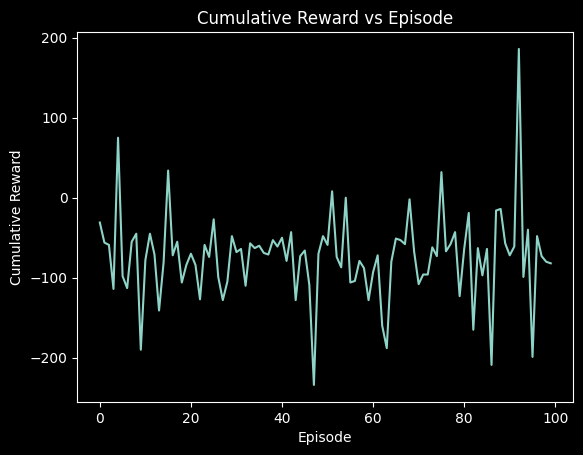

In [6]:
env = DisasterZone(grid_size=4, num_obstacles=5, num_survivors=4,
                   num_charging_stations=2, max_battery_life=10)

agent = DQNAgent(env)

num_episodes = 100

rewards = agent.train(num_episodes)

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Episode')
plt.show()

### Now let's save the trained DQN model for future usage.

In [7]:
model_filename = "Models/dqn_model.h5"
agent.model.save(model_filename)
print("Model saved successfully.")

Model saved successfully.


### Let's load the saved DQN model to use it.

In [8]:
model_filename = "Models/dqn_model.h5"
loaded_model = load_model(model_filename)
print("Model loaded successfully.")

Model loaded successfully.


### After training the Q-learning agent, we can extract symbolic knowledge in the form of IF-THEN rules from the learned Q-table. We can cluster states based on their Q-values and generate rules that represent the best action for a given cluster.

Here's an algorithm to extract symbolic knowledge from the learned Q-table:

1. Normalize the Q-values in the Q-table.
2. Perform k-means clustering on the normalized Q-values to group similar states.
3. For each cluster, generate an IF-THEN rule that represents the best action for the states in the cluster.

In [ ]:
from random import randint

def generate_random_state(env):
    grid = np.zeros((env.grid_size, env.grid_size), dtype=int)

    # Random agent position
    agent_pos = (randint(0, env.grid_size - 1), randint(0, env.grid_size - 1))
    grid[agent_pos] = 4

    # Random disaster positions
    for _ in range(env.num_disasters):
        while True:
            disaster_pos = (randint(0, env.grid_size - 1), randint(0, env.grid_size - 1))
            if grid[disaster_pos] == 0:
                grid[disaster_pos] = 1
                break

    # Random safe zone positions
    for _ in range(env.num_safe_zones):
        while True:
            safe_pos = (randint(0, env.grid_size - 1), randint(0, env.grid_size - 1))
            if grid[safe_pos] == 0:
                grid[safe_pos] = 2
                break

    # Flatten the grid and remove the agent's position
    state = grid.flatten()
    state = np.delete(state, np.where(state == 4))

    return state, agent_pos

def extract_rules(q_net, env, n_samples=1000, top_percentage=0.1):
    state_action_values = []

    for _ in range(n_samples):
        state, agent_pos = generate_random_state(env)
        action = randint(0, env.action_space.n - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
        q_values = q_net(state_tensor)
        state_action_value = q_values.detach().cpu().numpy()[0, action]
        state_action_values.append((state, agent_pos, action, state_action_value))

    state_action_values.sort(key=lambda x: x[3], reverse=True)
    top_state_action_values = state_action_values[:int(n_samples * top_percentage)]

    rules = []
    for action in range(env.action_space.n):
        states = [(state, agent_pos) for state, agent_pos, rule_action, _ in top_state_action_values if rule_action == action]
        rules.append({'states': states, 'action': action})

    return rules

n_samples = 1000
top_percentage = 0.1
rules = extract_rules(agent.q_net, env, n_samples, top_percentage)

# Print a sample of the IF-THEN rules
for rule in rules[:3]:
    if rule['states']:
        print('IF')
        print()
        for state in rule['states'][:3]:
            grid = np.array(state).reshape(env.grid_size, env.grid_size)
            for row in grid:
                print(" ".join(["." if cell == 0 else "C" if cell == 1 else "S" if cell ==
                      2 else "X" if cell == 3 else "A" for cell in row]))
            print()
        print(f"THEN {['Up', 'Down', 'Right', 'Left'][rule['action']]}")
        print()
        print("----------")
        print()


### Now we have a set of IF-THEN rules that represent the Q-learning agent's policy. Each rule maps a set of states (represented by their flattened grid) to the best action for those states.

### The quality of the extracted rules depends on the chosen clustering algorithm, the number of clusters, and how well the agent learned the optimal policy. We might need to experiment with different parameters and algorithms to find the best approach for our specific problem.